In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('housing.csv')

In [3]:
df.shape

(20640, 10)

In [4]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [7]:
df=df.dropna(subset='total_bedrooms')

In [8]:
df.duplicated().sum()

0

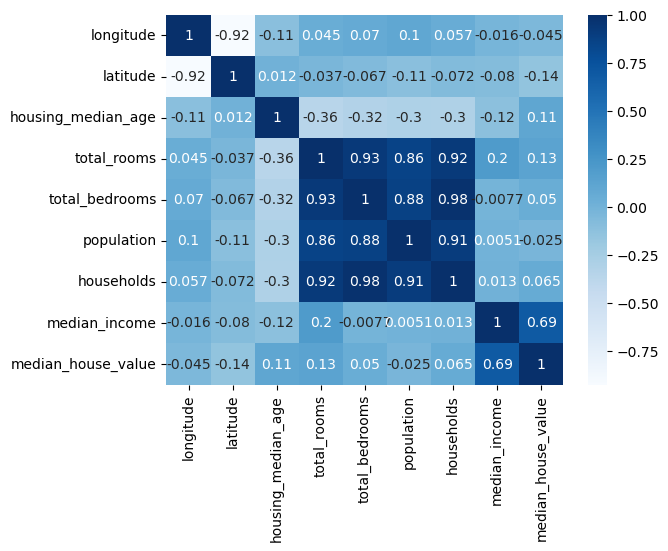

In [9]:
num_cols=df.select_dtypes(include=['float64'])
sns.heatmap(num_cols.corr(),annot=True,cmap='Blues')
plt.show()

In [13]:
df.columns = df.columns.str.strip()

In [12]:
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(" ", "_")

if "total_bedrooms" in df.columns:
    df["total_bedrooms"] = df["total_bedrooms"].fillna(df["total_bedrooms"].median())

if "ocean_proximity" in df.columns:
    df = pd.get_dummies(df, columns=["ocean_proximity"], drop_first=True)

In [14]:
target = "median_house_value"
features = [c for c in df.columns if c != target]

X = df[features].copy()
y = df[target].copy()


In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb.fit(X_train, y_train)

xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 5, 7]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500}


In [16]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.2f}")

RMSE: 46872.07
R²: 0.839
MAE: 30536.06


In [17]:
import pickle

with open("xgb_housing_model.pkl", "wb") as f:
    pickle.dump(best_model, f)